# 🫁 State-of-the-Art Pneumothorax Segmentation

**A comprehensive deep learning pipeline for medical image segmentation**

### Key Features (Refined):
- ✅ **UNet++ with Attention** + ResNet34 encoder (better skip connections)
- ✅ **Max pooling mask downsampling** (preserves small pneumothorax regions!)
- ✅ **SMP's DiceLoss + BCE hybrid** (well-tested implementation)
- ✅ **256×256 resolution** (matches working baseline)
- ✅ **Grayscale normalization** (0.5, 0.5, 0.5) for medical images
- ⭐ **Kaggle winner tricks**: Class rebalancing, optimal threshold, TTA
- ✅ **Early stopping** with patience monitoring
- ✅ **Mixed precision training** for speed

**Target: Dice Coefficient > 0.85**


---
## 1. Setup & Imports


In [1]:
# Install dependencies if needed (uncomment if required)
# !pip install segmentation-models-pytorch albumentations opencv-python-headless


In [2]:
import os

# Fix HuggingFace progress bar errors in notebooks
os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import Tuple, Optional, Dict, List
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split, StratifiedKFold

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.2 GB


---
## 2. Configuration ⚙️

**Adjust these settings based on your GPU**


In [3]:
class Config:
    """Training configuration - adjust for your hardware."""
    
    # === DATA PATHS ===
    DATA_PATH = "siim-acr-pneumothorax"
    TRAIN_CSV = "stage_1_train_images.csv"
    TEST_CSV = "stage_1_test_images.csv"
    IMAGES_DIR = "png_images"
    MASKS_DIR = "png_masks"
    OUTPUT_DIR = "sota_output"
    
    # === MODEL SETTINGS ===
    ENCODER = "resnet34"             # CHANGED: Simpler, proven for medical imaging
    ENCODER_WEIGHTS = "imagenet"
    ATTENTION_TYPE = "scse"          # Spatial + Channel attention
    
    # === IMAGE SETTINGS ===
    PATCH_SIZE = 256                 # CHANGED: Match original working notebook (256x256)
    USE_PATCHES = False               # DISABLED: Random crops can miss pneumothorax!
    
    # === TRAINING MODE ===
    # 🔄 SET THIS TO CHOOSE TRAINING MODE:
    USE_KFOLD = False                 # False = Single Split (faster), True = K-Fold CV (robust)
    N_FOLDS = 5                       # Number of folds (only if USE_KFOLD=True)
    VAL_SPLIT = 0.2                   # Validation split (only if USE_KFOLD=False)
    
    # === TRAINING SETTINGS ===
    # 🔧 ADJUST THESE FOR YOUR GPU:
    BATCH_SIZE = 16                    # RTX 4060 (8GB): use 4-8, RTX 3090: use 8-16
    GRADIENT_ACCUMULATION = 1         # Keep simple - no accumulation needed
    EPOCHS = 30                       # Max epochs per fold
    LEARNING_RATE = 3e-4              # CHANGED: More aggressive initial LR
    WEIGHT_DECAY = 1e-5               # CHANGED: Some regularization for generalization
    
    # === EARLY STOPPING ===
    PATIENCE = 10                     # Stop if no improvement for N epochs
    
    # === HARDWARE ===
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_WORKERS = 2                   # Data loading workers
    MIXED_PRECISION = True            # FP16 training (faster, less memory)
    
    SEED = 42

config = Config()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

print("📋 Configuration:")
print(f"   Device: {config.DEVICE}")
print(f"   Encoder: {config.ENCODER}")
print(f"   Patch Size: {config.PATCH_SIZE}")
print(f"   Batch Size: {config.BATCH_SIZE} (effective: {config.BATCH_SIZE * config.GRADIENT_ACCUMULATION})")
print(f"   Mode: {'K-Fold CV (K=' + str(config.N_FOLDS) + ')' if config.USE_KFOLD else 'Single Split (' + str(int(config.VAL_SPLIT*100)) + '% val)'}")
print(f"   Epochs: {config.EPOCHS}")
print(f"   Learning Rate: {config.LEARNING_RATE}")

# Set seeds
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(config.SEED)


📋 Configuration:
   Device: cuda
   Encoder: resnet34
   Patch Size: 256
   Batch Size: 16 (effective: 16)
   Mode: Single Split (20% val)
   Epochs: 30
   Learning Rate: 0.0003


---
## 3. Loss Functions & Augmentation

Using **Dice-BCE Hybrid Loss** for class imbalance and **Elastic Deformations** for medical imaging


In [4]:
# Loss Functions - Using SMP's well-tested implementations
# CHANGED: Use SMP's DiceLoss (well-tested, handles per-sample correctly)
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
bce_loss = nn.BCEWithLogitsLoss()

class DiceBCELoss(nn.Module):
    """Hybrid loss combining Dice and BCE for better convergence."""
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super().__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
        self.bce_loss = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        return self.dice_weight * self.dice_loss(pred, target) + self.bce_weight * self.bce_loss(pred, target)

# Augmentation Pipelines
def get_training_augmentation(patch_size=256):
    """
    MINIMAL augmentation matching the working baseline:
    - NO geometric transforms (baseline used none and got 0.79 Dice!)
    - Simple (0.5, 0.5, 0.5) normalization for grayscale X-rays
    - NO horizontal flip (chest anatomy is asymmetric)
    """
    return A.Compose([
        # CORRECT: Use grayscale-friendly normalization (not ImageNet!)
        # ImageNet stats are for RGB natural images, not grayscale X-rays
        A.Normalize(
            mean=(0.5, 0.5, 0.5),  # Neutral for grayscale
            std=(0.5, 0.5, 0.5)
        ),
        ToTensorV2()
    ])

def get_validation_augmentation():
    return A.Compose([
        # CORRECT: Use grayscale-friendly normalization (not ImageNet!)
        A.Normalize(
            mean=(0.5, 0.5, 0.5),  # Neutral for grayscale
            std=(0.5, 0.5, 0.5)
        ),
        ToTensorV2()
    ])

# Metrics - FIXED: Per-sample calculation then average (like original notebook)
def dice_coefficient(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate Dice per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    # Sum over spatial dims (H,W) per sample - keep batch dim!
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate IoU per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

print("✅ Loss functions and augmentations defined")


✅ Loss functions and augmentations defined


---
## 4. Dataset & Data Loading


In [5]:
class PneumothoraxDataset(Dataset):
    """Dataset with MAX POOLING for mask downsampling to preserve small regions."""
    
    def __init__(self, df, images_dir, masks_dir, transform=None, 
                 patch_size=256, is_training=True, use_patches=False):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.patch_size = patch_size
        self.is_training = is_training
        self.use_patches = use_patches
    
    def __len__(self):
        return len(self.df)
    
    def _max_pool_downsample_mask(self, mask, target_size):
        """
        KEY IMPROVEMENT: Use max pooling to preserve small pneumothorax regions.
        Standard cv2.resize() can lose small regions during 1024→256 downsampling.
        Max pooling ensures any positive pixel in each 4x4 block is preserved.
        """
        h, w = mask.shape
        if h == target_size and w == target_size:
            return mask
        
        ratio = h // target_size
        if ratio > 1 and h % target_size == 0 and w % target_size == 0:
            # Perfect divisibility - use efficient reshape + max
            mask_reshaped = mask.reshape(target_size, ratio, target_size, ratio)
            mask_downsampled = mask_reshaped.max(axis=(1, 3))
            return mask_downsampled
        else:
            # Fallback to nearest neighbor (still better than bilinear for masks)
            return cv2.resize(mask, (target_size, target_size), interpolation=cv2.INTER_NEAREST)
    
    def _random_crop(self, image, mask):
        h, w = image.shape[:2]
        max_y, max_x = max(0, h - self.patch_size), max(0, w - self.patch_size)
        if max_y == 0 and max_x == 0:
            image = cv2.resize(image, (self.patch_size, self.patch_size))
            mask = self._max_pool_downsample_mask(mask, self.patch_size)
            return image, mask
        y, x = np.random.randint(0, max_y + 1), np.random.randint(0, max_x + 1)
        return image[y:y+self.patch_size, x:x+self.patch_size], mask[y:y+self.patch_size, x:x+self.patch_size]
    
    def __getitem__(self, idx):
        filename = self.df.iloc[idx]['new_filename']
        image = cv2.imread(os.path.join(self.images_dir, filename), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(self.masks_dir, filename), cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        if self.use_patches and self.is_training:
            image, mask = self._random_crop(image, mask)
        else:
            # CHANGED: Use max pooling for masks to preserve small pneumothorax regions!
            image = cv2.resize(image, (self.patch_size, self.patch_size))
            mask = self._max_pool_downsample_mask(mask, self.patch_size)
        
        mask = (mask > 127).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']
        
        mask = mask.permute(2, 0, 1) if mask.dim() == 3 else mask.unsqueeze(0)
        return image, mask

print("✅ Dataset class defined")


✅ Dataset class defined


In [6]:
# Load CSV and filter corrupted images (with GPU acceleration using torch and torchvision)
from concurrent.futures import ThreadPoolExecutor
import torch
import torchvision.io

train_csv_path = os.path.join(config.DATA_PATH, config.TRAIN_CSV)
df_raw = pd.read_csv(train_csv_path)
images_dir = os.path.join(config.DATA_PATH, config.IMAGES_DIR)
masks_dir = os.path.join(config.DATA_PATH, config.MASKS_DIR)

print(f"📁 Total samples in CSV: {len(df_raw)}")
print(f"📂 Images dir: {images_dir} (exists: {os.path.exists(images_dir)})")
print(f"📂 Masks dir: {masks_dir} (exists: {os.path.exists(masks_dir)})")

def validate_sample(idx):
    filename = df_raw.iloc[idx]['new_filename']
    image_path = os.path.join(images_dir, filename)
    mask_path = os.path.join(masks_dir, filename)
    try:
        # Use torchvision.io.read_image for GPU tensor if available
        device = "cuda" if torch.cuda.is_available() else "cpu"
        img = torchvision.io.read_image(image_path).to(device)
        # Convert to grayscale if needed (our png is grayscale but we might get as C,H,W)
        if img.shape[0] > 1:
            img = img.mean(dim=0, keepdim=True)
        h, w = img.shape[1:]
        img_mean = img.float().mean().item()
        mask = torchvision.io.read_image(mask_path).to(device)
        if mask.shape[0] > 1:
            mask = mask.mean(dim=0, keepdim=True)
        mask_max = mask.max().item() if mask is not None else 0
        if img is not None and h > 100 and w > 100 and img_mean > 5:
            # Valid image
            return idx, 1 if mask is not None and mask_max > 0 else 0, None
        else:
            return None, None, filename
    except Exception as e:
        return None, None, filename

# GPU-accelerated "validation" of each image/mask sample using threads
print("\n🔍 Validating all images and computing stratification (accelerated)...")
valid_indices = []
has_pneumothorax = []
corrupted_files = []

with ThreadPoolExecutor(max_workers=16) as executor:
    futures = [executor.submit(validate_sample, idx) for idx in range(len(df_raw))]
    for f in tqdm(futures, desc="Checking images"):
        try:
            idx, pneumo, corrupt = f.result()
            if idx is not None:
                valid_indices.append(idx)
                has_pneumothorax.append(pneumo)
            elif corrupt:
                corrupted_files.append(corrupt)
        except Exception:
            # This should not happen, but just in case
            continue

# Create filtered dataframe
df = df_raw.iloc[valid_indices].reset_index(drop=True)
has_pneumothorax = np.array(has_pneumothorax)

print(f"\n📊 Data Summary:")
print(f"   Original samples: {len(df_raw)}")
print(f"   Valid samples: {len(df)}")
if corrupted_files:
    print(f"   ⚠️ Filtered out: {len(corrupted_files)} corrupted/invalid images")
    print(f"   Examples: {corrupted_files[:5]}")

print(f"\n📊 Class distribution (valid images only):")
print(f"   With pneumothorax: {has_pneumothorax.sum()} ({100*has_pneumothorax.mean():.1f}%)")
print(f"   Without: {len(has_pneumothorax) - has_pneumothorax.sum()} ({100*(1-has_pneumothorax.mean()):.1f}%)")


📁 Total samples in CSV: 10675
📂 Images dir: siim-acr-pneumothorax/png_images (exists: True)
📂 Masks dir: siim-acr-pneumothorax/png_masks (exists: True)

🔍 Validating all images and computing stratification (accelerated)...


Checking images:   0%|          | 0/10675 [00:00<?, ?it/s]

libpng error: IDAT: CRC error



📊 Data Summary:
   Original samples: 10675
   Valid samples: 10674
   ⚠️ Filtered out: 1 corrupted/invalid images
   Examples: ['5548_train_0_.png']

📊 Class distribution (valid images only):
   With pneumothorax: 2379 (22.3%)
   Without: 8295 (77.7%)


In [ ]:
# Create train/val split and dataloaders
from torch.utils.data import WeightedRandomSampler

train_df, val_df = train_test_split(df, test_size=config.VAL_SPLIT, stratify=has_pneumothorax, random_state=config.SEED)

train_dataset = PneumothoraxDataset(train_df, images_dir, masks_dir, get_training_augmentation(config.PATCH_SIZE), 
                                     config.PATCH_SIZE, is_training=True, use_patches=config.USE_PATCHES)
val_dataset = PneumothoraxDataset(val_df, images_dir, masks_dir, get_validation_augmentation(), 
                                   config.PATCH_SIZE, is_training=False, use_patches=False)

# ⭐ KAGGLE TRICK #1: Class Rebalancing via WeightedRandomSampler
# Oversample positive cases to get ~50/50 balance per epoch
train_has_pneumothorax = has_pneumothorax[train_df.index.values]
class_counts = np.bincount(train_has_pneumothorax.astype(int))
class_weights = 1.0 / class_counts  # Inverse frequency
sample_weights = class_weights[train_has_pneumothorax.astype(int)]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, sampler=sampler,  # Use sampler instead of shuffle
                          num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
                        num_workers=config.NUM_WORKERS, pin_memory=True)

print(f"\n📂 Data split: Train={len(train_df)}, Val={len(val_df)}")
print(f"   Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
print(f"   ⭐ Class rebalancing enabled: Positive cases oversampled for ~50/50 balance")



📂 Data split: Train=8539, Val=2135
   Train batches: 533, Val batches: 134


---
## 5. Model & Training Setup 🧠


In [8]:
# Create UNet++ model (better than vanilla U-Net with nested skip connections)
# CHANGED: UnetPlusPlus has better feature fusion via nested/dense skip pathways
model = smp.UnetPlusPlus(
    encoder_name=config.ENCODER, 
    encoder_weights=config.ENCODER_WEIGHTS,
    in_channels=3, 
    classes=1, 
    activation=None, 
    decoder_attention_type=config.ATTENTION_TYPE
)
model = model.to(config.DEVICE)

# Training setup
criterion = DiceBCELoss(dice_weight=0.5, bce_weight=0.5)
# CHANGED: AdamW with weight decay for better generalization
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
# Keep ReduceLROnPlateau - adapts to validation performance
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
scaler = GradScaler(enabled=config.MIXED_PRECISION)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n🧠 Model: UNet++ with Attention ({config.ENCODER})")
print(f"   Parameters: {total_params:,}")
print(f"   Loss: DiceBCE Hybrid (SMP implementation)")
print(f"   Optimizer: AdamW (lr={config.LEARNING_RATE}, wd={config.WEIGHT_DECAY})")
print(f"   Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")



🧠 Model: UNet++ with Attention (resnet34)
   Parameters: 26,281,332
   Loss: DiceBCE Hybrid (SMP implementation)
   Optimizer: AdamW (lr=0.0003, wd=1e-05)
   Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)


---
## 6. Training Loop 🚀

**Choose ONE of the following cells based on your config:**
- Cell 6A: Single Split Training (when `USE_KFOLD = False`)
- Cell 6B: K-Fold Cross-Validation (when `USE_KFOLD = True`)

### 6A. Single Split Training (Default - Faster)


In [ ]:
# ⚠️ RUN THIS CELL ONLY IF USE_KFOLD = False
if config.USE_KFOLD:
    print("⚠️ USE_KFOLD is True - Skip this cell and run Section 6B instead!")
    best_dice = 0.0  # Placeholder
    best_iou = 0.0
    history = {}
    best_model_path = ""
else:
    # Training history
    history = {'train_loss': [], 'train_dice': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
    best_dice = 0.0
    best_iou = 0.0
    patience_counter = 0
    best_model_path = None  # Will be set when saving

    print("=" * 60)
    print("🚀 STARTING SINGLE-SPLIT TRAINING")
    print("=" * 60)
    
    for epoch in range(config.EPOCHS):
        # === TRAINING ===
        model.train()
        train_loss, train_dice = 0.0, 0.0
        optimizer.zero_grad()
        
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{config.EPOCHS}")
        for batch_idx, (images, masks) in pbar:
            images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)
            
            with autocast(enabled=config.MIXED_PRECISION):
                outputs = model(images)
                loss = criterion(outputs, masks) / config.GRADIENT_ACCUMULATION
            
            scaler.scale(loss).backward()
            
            if (batch_idx + 1) % config.GRADIENT_ACCUMULATION == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            train_loss += loss.item() * config.GRADIENT_ACCUMULATION * images.size(0)
            train_dice += dice_coefficient(outputs, masks).item() * images.size(0)
            pbar.set_postfix({'loss': f'{loss.item()*config.GRADIENT_ACCUMULATION:.4f}'})
        
        train_loss /= len(train_loader.dataset)
        train_dice /= len(train_loader.dataset)
        
        # === VALIDATION ===
        model.eval()
        val_loss, val_dice, val_iou = 0.0, 0.0, 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)
                with autocast(enabled=config.MIXED_PRECISION):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                val_dice += dice_coefficient(outputs, masks).item() * images.size(0)
                val_iou += iou_score(outputs, masks).item() * images.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)
        
        scheduler.step(val_dice)  # FIXED: ReduceLROnPlateau needs the metric value
        # scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        
        print(f"\n📊 Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Dice={train_dice:.4f}")
        print(f"   Val Loss={val_loss:.4f}, Val Dice={val_dice:.4f}, Val IoU={val_iou:.4f}")
        
        # Save best model with metrics in filename
        if val_dice > best_dice:
            best_dice = val_dice
            best_iou = val_iou
            patience_counter = 0
            # Create descriptive filename: pneumo_dice{D}_iou{I}_ep{E}.pth
            model_name = f"pneumo_dice{val_dice:.4f}_iou{val_iou:.4f}_ep{epoch+1}.pth"
            best_model_path = os.path.join(config.OUTPUT_DIR, model_name)
            torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 
                        'val_dice': val_dice, 'val_iou': val_iou, 'history': history,
                        'encoder': config.ENCODER, 'patch_size': config.PATCH_SIZE}, best_model_path)
            print(f"   ✅ New best model saved: {model_name}")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement ({patience_counter}/{config.PATIENCE})")
        
        if patience_counter >= config.PATIENCE:
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            break

    print("\n" + "=" * 60)
    print(f"🎉 TRAINING COMPLETE! Best Dice: {best_dice:.4f}")
    print("=" * 60)


🚀 STARTING SINGLE-SPLIT TRAINING


Epoch 1/30:   0%|          | 0/533 [00:00<?, ?it/s]


📊 Epoch 1: Train Loss=0.4744, Train Dice=0.4421
   Val Loss=0.4269, Val Dice=0.7475, Val IoU=0.7396
   ✅ New best model saved: pneumo_dice0.7475_iou0.7396_ep1.pth


Epoch 2/30:   0%|          | 0/533 [00:00<?, ?it/s]


📊 Epoch 2: Train Loss=0.3948, Train Dice=0.5966
   Val Loss=0.3969, Val Dice=0.5229, Val IoU=0.5037
   ⏳ No improvement (1/10)


Epoch 3/30:   0%|          | 0/533 [00:00<?, ?it/s]


📊 Epoch 3: Train Loss=0.3556, Train Dice=0.6738
   Val Loss=0.4023, Val Dice=0.5412, Val IoU=0.5241
   ⏳ No improvement (2/10)


Epoch 4/30:   0%|          | 0/533 [00:00<?, ?it/s]

### 6B. K-Fold Cross-Validation (Optional - More Robust)

⚠️ **Run this cell ONLY if `USE_KFOLD = True` in config**


In [ ]:
# ⚠️ RUN THIS CELL ONLY IF USE_KFOLD = True
if not config.USE_KFOLD:
    print("⚠️ USE_KFOLD is False - Skip this cell, you already ran 6A!")
    fold_results = []
else:
    print("=" * 60)
    print(f"🚀 STARTING {config.N_FOLDS}-FOLD CROSS-VALIDATION")
    print("=" * 60)
    
    kfold = StratifiedKFold(n_splits=config.N_FOLDS, shuffle=True, random_state=config.SEED)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df, has_pneumothorax)):
        print(f"\n{'='*60}")
        print(f"📁 FOLD {fold+1}/{config.N_FOLDS}")
        print(f"{'='*60}")
        
        # Split data
        fold_train_df = df.iloc[train_idx]
        fold_val_df = df.iloc[val_idx]
        print(f"   Train: {len(fold_train_df)}, Val: {len(fold_val_df)}")
        
        # Create datasets
        fold_train_dataset = PneumothoraxDataset(
            fold_train_df, images_dir, masks_dir, 
            get_training_augmentation(config.PATCH_SIZE),
            config.PATCH_SIZE, is_training=True, use_patches=config.USE_PATCHES
        )
        fold_val_dataset = PneumothoraxDataset(
            fold_val_df, images_dir, masks_dir,
            get_validation_augmentation(),
            config.PATCH_SIZE, is_training=False, use_patches=False
        )
        
        fold_train_loader = DataLoader(fold_train_dataset, batch_size=config.BATCH_SIZE,
                                       shuffle=True, num_workers=config.NUM_WORKERS, 
                                       pin_memory=True, drop_last=True)
        fold_val_loader = DataLoader(fold_val_dataset, batch_size=config.BATCH_SIZE,
                                     shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)
        
        # Fresh model for each fold - UNet++ with nested skip connections
        fold_model = smp.UnetPlusPlus(
            encoder_name=config.ENCODER, 
            encoder_weights=config.ENCODER_WEIGHTS,
            in_channels=3, 
            classes=1, 
            activation=None, 
            decoder_attention_type=config.ATTENTION_TYPE
        ).to(config.DEVICE)
        
        # CHANGED: AdamW + ReduceLROnPlateau
        fold_optimizer = torch.optim.AdamW(fold_model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
        fold_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(fold_optimizer, mode='max', factor=0.5, patience=3)
        fold_scaler = GradScaler(enabled=config.MIXED_PRECISION)
        
        fold_history = {'train_loss': [], 'train_dice': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
        fold_best_dice = 0.0
        fold_best_iou = 0.0
        fold_patience = 0
        fold_model_path = None  # Will be set when saving
        
        for epoch in range(config.EPOCHS):
            # Training
            fold_model.train()
            train_loss, train_dice = 0.0, 0.0
            fold_optimizer.zero_grad()
            
            pbar = tqdm(enumerate(fold_train_loader), total=len(fold_train_loader), 
                       desc=f"Fold {fold+1} Epoch {epoch+1}", leave=False)
            for batch_idx, (images, masks) in pbar:
                images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)
                with autocast(enabled=config.MIXED_PRECISION):
                    outputs = fold_model(images)
                    loss = criterion(outputs, masks) / config.GRADIENT_ACCUMULATION
                fold_scaler.scale(loss).backward()
                if (batch_idx + 1) % config.GRADIENT_ACCUMULATION == 0:
                    fold_scaler.step(fold_optimizer)
                    fold_scaler.update()
                    fold_optimizer.zero_grad()
                train_loss += loss.item() * config.GRADIENT_ACCUMULATION * images.size(0)
                train_dice += dice_coefficient(outputs, masks).item() * images.size(0)
            
            train_loss /= len(fold_train_loader.dataset)
            train_dice /= len(fold_train_loader.dataset)
            
            # Validation
            fold_model.eval()
            val_loss, val_dice, val_iou = 0.0, 0.0, 0.0
            with torch.no_grad():
                for images, masks in fold_val_loader:
                    images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)
                    with autocast(enabled=config.MIXED_PRECISION):
                        outputs = fold_model(images)
                        loss = criterion(outputs, masks)
                    val_loss += loss.item() * images.size(0)
                    val_dice += dice_coefficient(outputs, masks).item() * images.size(0)
                    val_iou += iou_score(outputs, masks).item() * images.size(0)
            
            val_loss /= len(fold_val_loader.dataset)
            val_dice /= len(fold_val_loader.dataset)
            val_iou /= len(fold_val_loader.dataset)
            
            fold_scheduler.step(val_dice)  # FIXED: ReduceLROnPlateau needs the metric value
            # fold_scheduler.step()
            fold_history['train_loss'].append(train_loss)
            fold_history['train_dice'].append(train_dice)
            fold_history['val_loss'].append(val_loss)
            fold_history['val_dice'].append(val_dice)
            fold_history['val_iou'].append(val_iou)
            
            # Save best model with metrics in filename
            if val_dice > fold_best_dice:
                fold_best_dice = val_dice
                fold_best_iou = val_iou
                fold_patience = 0
                # Create descriptive filename: pneumo_fold{F}_dice{D}_iou{I}_ep{E}.pth
                model_name = f"pneumo_fold{fold}_dice{val_dice:.4f}_iou{val_iou:.4f}_ep{epoch+1}.pth"
                fold_model_path = os.path.join(config.OUTPUT_DIR, model_name)
                torch.save({'fold': fold, 'epoch': epoch, 'model_state_dict': fold_model.state_dict(),
                           'val_dice': val_dice, 'val_iou': val_iou, 'history': fold_history,
                           'encoder': config.ENCODER, 'patch_size': config.PATCH_SIZE}, fold_model_path)
            else:
                fold_patience += 1
            
            if fold_patience >= config.PATIENCE:
                print(f"   Early stopping at epoch {epoch+1}")
                break
        
        fold_results.append({'fold': fold, 'best_dice': fold_best_dice, 'best_iou': fold_best_iou, 
                             'history': fold_history, 'model_path': fold_model_path})
        print(f"   ✅ Fold {fold+1} Best Dice: {fold_best_dice:.4f}, IoU: {fold_best_iou:.4f}")
    
    # Summary
    fold_dices = [r['best_dice'] for r in fold_results]
    fold_ious = [r['best_iou'] for r in fold_results]
    best_fold_idx = np.argmax(fold_dices)
    best_dice = np.mean(fold_dices)
    best_iou = np.mean(fold_ious)
    history = fold_results[best_fold_idx]['history']  # Use best fold's history for plotting
    best_model_path = fold_results[best_fold_idx]['model_path']  # Best fold's model path
    
    print("\n" + "=" * 60)
    print("📊 K-FOLD CROSS-VALIDATION RESULTS")
    print("=" * 60)
    for i, (d, iou) in enumerate(zip(fold_dices, fold_ious)):
        print(f"   Fold {i+1}: Dice = {d:.4f}, IoU = {iou:.4f}")
    print("-" * 40)
    print(f"   Mean Dice: {np.mean(fold_dices):.4f} ± {np.std(fold_dices):.4f}")
    print(f"   Mean IoU:  {np.mean(fold_ious):.4f} ± {np.std(fold_ious):.4f}")
    print(f"   Best Fold: {best_fold_idx+1} (Dice: {max(fold_dices):.4f})")
    print("=" * 60)


---
## 7. Kaggle Tricks: Optimal Threshold & TTA 🎯

⭐ **Post-Training Enhancements** to boost performance


In [ ]:
# ⭐ KAGGLE TRICK #2: Find Optimal Threshold
# Don't just use 0.5! Find the threshold that maximizes Dice on validation set

def find_optimal_threshold(model, val_loader, device, search_range=(0.3, 0.7, 0.05)):
    """Find threshold that maximizes Dice coefficient on validation set."""
    model.eval()
    all_preds = []
    all_masks = []
    
    print("🔍 Collecting predictions on validation set...")
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Predicting"):
            outputs = torch.sigmoid(model(images.to(device)))
            all_preds.append(outputs.cpu())
            all_masks.append(masks)
    
    all_preds = torch.cat(all_preds)
    all_masks = torch.cat(all_masks)
    
    best_threshold = 0.5
    best_dice = 0.0
    
    print(f"\n🎯 Searching for optimal threshold in range {search_range[0]:.2f}-{search_range[1]:.2f}...")
    thresholds = np.arange(search_range[0], search_range[1], search_range[2])
    
    for threshold in thresholds:
        pred_binary = (all_preds > threshold).float()
        dice = dice_coefficient(pred_binary, all_masks, threshold=0.5).item()  # threshold param not used since already binary
        
        if dice > best_dice:
            best_dice = dice
            best_threshold = threshold
        print(f"   Threshold {threshold:.2f}: Dice = {dice:.4f}")
    
    print(f"\n✅ Optimal threshold: {best_threshold:.2f}")
    print(f"   Dice improvement: {best_dice:.4f} (vs {dice_coefficient((all_preds > 0.5).float(), all_masks).item():.4f} at 0.5)")
    return best_threshold, best_dice

# Find optimal threshold if training completed
if 'best_model_path' in locals() and best_model_path and os.path.exists(best_model_path):
    optimal_threshold, optimal_dice = find_optimal_threshold(model, val_loader, config.DEVICE)
else:
    optimal_threshold = 0.5
    print("⚠️ No trained model found, using default threshold=0.5")


In [ ]:
# ⭐ KAGGLE TRICK #3: Test-Time Augmentation (TTA)
# Apply horizontal flip during inference and average predictions

def predict_with_tta(model, image, device, threshold=0.5):
    """
    Apply Test-Time Augmentation for more robust predictions.
    
    For chest X-rays, we only flip horizontally (not vertically).
    Pneumothorax can occur on either side, so horizontal flip is valid.
    """
    model.eval()
    with torch.no_grad():
        # Original prediction
        pred1 = torch.sigmoid(model(image.unsqueeze(0).to(device)))
        
        # Horizontal flip prediction
        image_hflip = torch.flip(image, [2])  # flip width dimension
        pred2 = torch.sigmoid(model(image_hflip.unsqueeze(0).to(device)))
        pred2 = torch.flip(pred2, [3])  # flip prediction back
        
        # Average predictions
        pred_avg = (pred1 + pred2) / 2
    
    # Apply threshold
    pred_binary = (pred_avg > threshold).float()
    return pred_avg.squeeze().cpu().numpy(), pred_binary.squeeze().cpu().numpy()

print("✅ TTA function defined")


---
## 8. Training Curves 📈


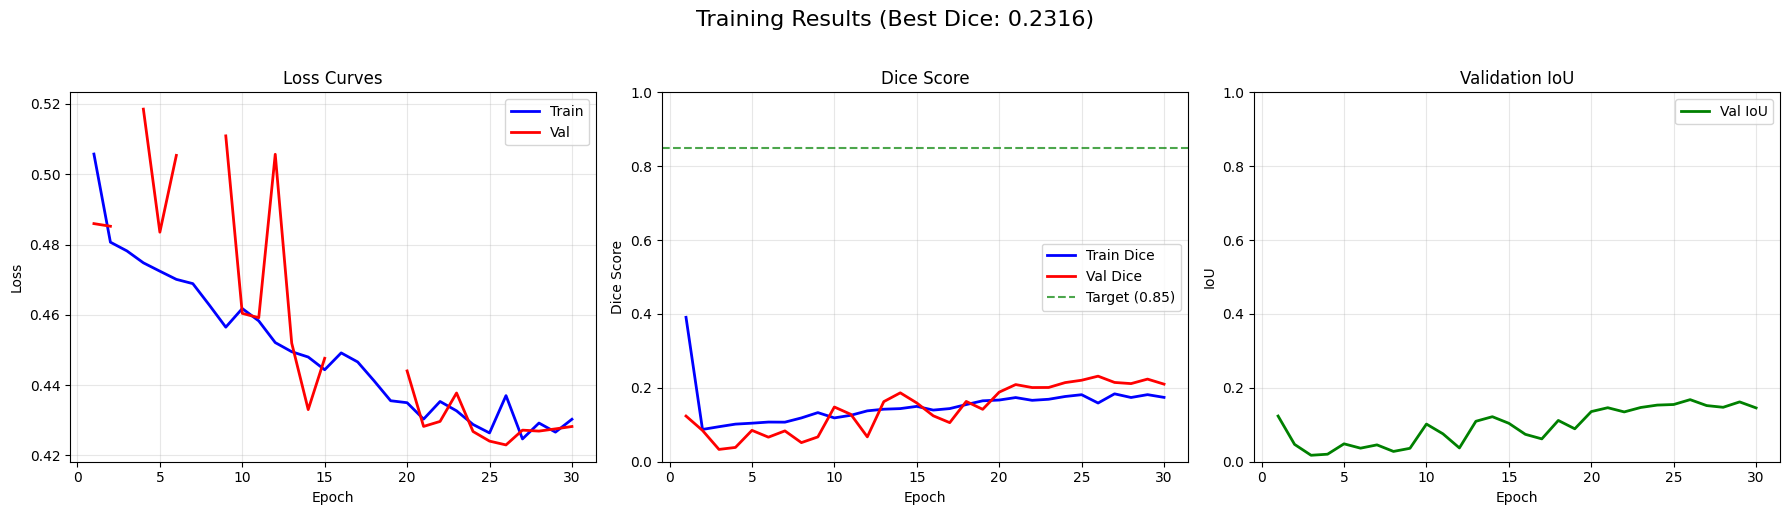

In [ ]:
if history and len(history.get('train_loss', [])) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, len(history['train_loss']) + 1)

    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].set_title('Loss Curves')
    axes[0].legend(); axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, history['train_dice'], 'b-', label='Train Dice', linewidth=2)
    axes[1].plot(epochs, history['val_dice'], 'r-', label='Val Dice', linewidth=2)
    axes[1].axhline(y=0.85, color='green', linestyle='--', label='Target (0.85)', alpha=0.7)
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Dice Score'); axes[1].set_title('Dice Score')
    axes[1].legend(); axes[1].grid(True, alpha=0.3); axes[1].set_ylim(0, 1)

    axes[2].plot(epochs, history['val_iou'], 'g-', label='Val IoU', linewidth=2)
    axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('IoU'); axes[2].set_title('Validation IoU')
    axes[2].legend(); axes[2].grid(True, alpha=0.3); axes[2].set_ylim(0, 1)

    title = f'Training Results (Best Dice: {best_dice:.4f})' if not config.USE_KFOLD else f'Best Fold Results (Dice: {max([r["best_dice"] for r in fold_results]):.4f})'
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ No training history to plot")


---
## 9. Visualize Predictions with TTA 🎯

Using **optimal threshold** and **Test-Time Augmentation** for best results


✅ Loaded best model: pneumo_dice0.2316_iou0.1681_ep26.pth
   Dice: 0.2316, IoU: 0.1680597694414462


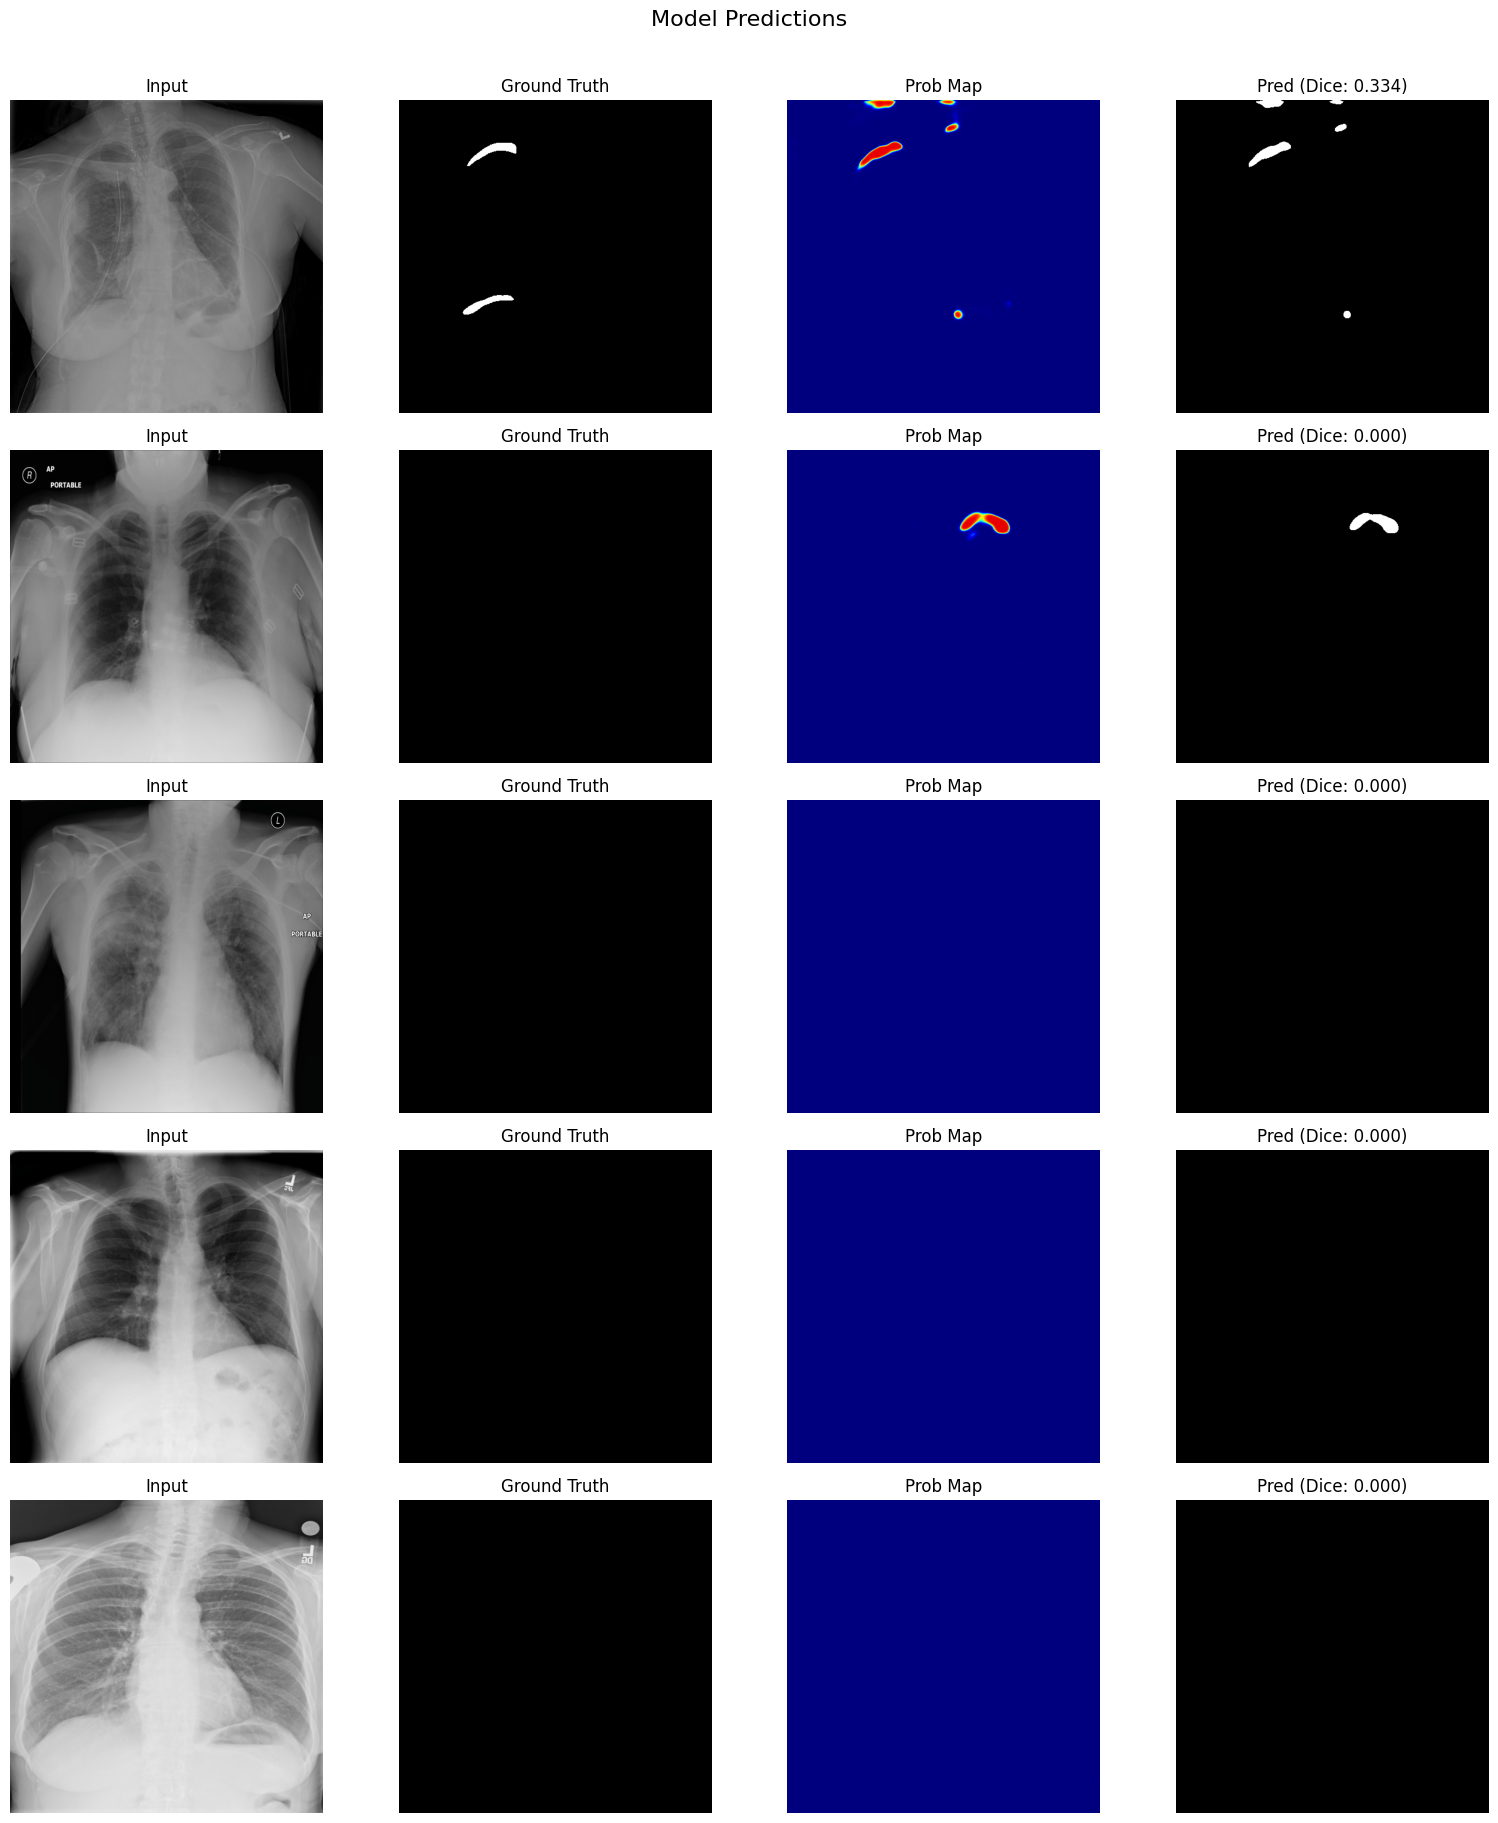

In [ ]:
# Load best model
if best_model_path and os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"✅ Loaded best model: {os.path.basename(best_model_path)}")
    print(f"   Dice: {checkpoint['val_dice']:.4f}, IoU: {checkpoint.get('val_iou', 'N/A')}")
else:
    print("⚠️ No model checkpoint found - skipping predictions")

# Visualize predictions with TTA and optimal threshold
# CORRECT: Use same normalization as training (0.5, 0.5, 0.5) for grayscale
GRAYSCALE_MEAN = np.array([0.5, 0.5, 0.5])
GRAYSCALE_STD = np.array([0.5, 0.5, 0.5])

# Use optimal threshold if found, otherwise default to 0.5
threshold = optimal_threshold if 'optimal_threshold' in locals() else 0.5
print(f"\n🎯 Using threshold: {threshold:.2f} for predictions")

fig, axes = plt.subplots(5, 4, figsize=(16, 18))
indices = np.random.choice(len(val_dataset), 5, replace=False)

for i, idx in enumerate(indices):
    image, mask = val_dataset[idx]
    
    # ⭐ Use TTA for more robust predictions
    if 'predict_with_tta' in globals():
        pred_prob, pred_binary = predict_with_tta(model, image, config.DEVICE, threshold=threshold)
    else:
        # Fallback to standard prediction
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(config.DEVICE))
            pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()
            pred_binary = (pred_prob > threshold).astype(float)
    
    img = image.permute(1, 2, 0).numpy()
    # Denormalize using same stats as training
    img = img * GRAYSCALE_STD + GRAYSCALE_MEAN
    img = np.clip(img, 0, 1)
    mask_np = mask.squeeze().numpy()
    
    intersection = (pred_binary * mask_np).sum()
    sample_dice = 2 * intersection / (pred_binary.sum() + mask_np.sum() + 1e-6)
    
    axes[i, 0].imshow(img); axes[i, 0].set_title('Input'); axes[i, 0].axis('off')
    axes[i, 1].imshow(mask_np, cmap='gray'); axes[i, 1].set_title('Ground Truth'); axes[i, 1].axis('off')
    axes[i, 2].imshow(pred_prob, cmap='jet', vmin=0, vmax=1); axes[i, 2].set_title(f'Prob (T={threshold:.2f})'); axes[i, 2].axis('off')
    axes[i, 3].imshow(pred_binary, cmap='gray'); axes[i, 3].set_title(f'Pred+TTA (D={sample_dice:.3f})'); axes[i, 3].axis('off')

plt.suptitle('Model Predictions with TTA & Optimal Threshold', fontsize=16, y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'predictions_tta.png'), dpi=150, bbox_inches='tight')
plt.show()


---
## 10. Save Results 💾


In [ ]:
import json

# Build summary based on training mode
if config.USE_KFOLD and len(fold_results) > 0:
    fold_dices = [r['best_dice'] for r in fold_results]
    summary = {
        'mode': 'kfold',
        'n_folds': config.N_FOLDS,
        'mean_dice': float(np.mean(fold_dices)),
        'std_dice': float(np.std(fold_dices)),
        'fold_dices': [float(d) for d in fold_dices],
        'best_fold': int(np.argmax(fold_dices)),
        'config': {'encoder': config.ENCODER, 'patch_size': config.PATCH_SIZE,
                   'batch_size': config.BATCH_SIZE, 'learning_rate': config.LEARNING_RATE}
    }
    final_dice = np.mean(fold_dices)
    final_iou = np.mean([max(r['history']['val_iou']) for r in fold_results])
else:
    summary = {
        'mode': 'single_split',
        'best_dice': float(best_dice),
        'best_iou': float(max(history['val_iou'])) if history else 0,
        'epochs_trained': len(history['train_loss']) if history else 0,
        'config': {'encoder': config.ENCODER, 'patch_size': config.PATCH_SIZE, 
                   'batch_size': config.BATCH_SIZE, 'learning_rate': config.LEARNING_RATE},
        'history': {k: [float(x) for x in v] for k, v in history.items()} if history else {}
    }
    final_dice = best_dice
    final_iou = max(history['val_iou']) if history and 'val_iou' in history else 0

with open(os.path.join(config.OUTPUT_DIR, 'training_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n✅ Results saved to {config.OUTPUT_DIR}/")
if best_model_path:
    print(f"   - {os.path.basename(best_model_path)}")
print(f"   - training_curves.png")
print(f"   - predictions.png")
print(f"   - training_summary.json")

print("\n" + "=" * 60)
print("📊 FINAL SUMMARY")
print("=" * 60)
if config.USE_KFOLD and len(fold_results) > 0:
    print(f"🔄 Mode: {config.N_FOLDS}-Fold Cross-Validation")
    print(f"🏆 Mean Dice: {np.mean(fold_dices):.4f} ± {np.std(fold_dices):.4f}")
else:
    print(f"🔄 Mode: Single Split")
    print(f"🏆 Best Dice: {final_dice:.4f}")
    print(f"🏆 Best IoU:  {final_iou:.4f}")
print("=" * 60)

if final_dice >= 0.85:
    print("\n🎉 TARGET ACHIEVED! Dice ≥ 0.85")
else:
    print(f"\n📈 Dice {final_dice:.4f} - Consider more epochs or tuning")



✅ Results saved to sota_output/
   - pneumo_dice0.2316_iou0.1681_ep26.pth
   - training_curves.png
   - predictions.png
   - training_summary.json

📊 FINAL SUMMARY
🔄 Mode: Single Split
🏆 Best Dice: 0.2316
🏆 Best IoU:  0.1681

📈 Dice 0.2316 - Consider more epochs or tuning
